In [3]:
import pandas as pd
import pytz
from datetime import timedelta, date, datetime
import time
import matplotlib.pyplot as plt

In [4]:
#Initialize an empty dataframe to append the daily and hourly resampled data
dailyGridActivity = pd.DataFrame()
hourlyGridActivity = pd.DataFrame()

filename_constant = "Data/sms-call-internet-mi-{}.txt"
col_list = ['gridID', 'timeInterval', 'countryCode', 'smsIn', 'smsOut', 'callIn', 'callOut', 'internetActivity']

#Generating filenames iteratively
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2013, 11, 1)
end_date = date(2014, 1, 2)
for single_date in daterange(start_date, end_date):
    read_data = pd.read_csv(filename_constant.format(single_date.strftime("%Y-%m-%d")), sep='\t',header=None, names=col_list, parse_dates=True)
      
    #Check for null values (Execute until this point seperately before proceeding ahead)
    #print(filename_constant.format(single_date.strftime("%Y-%m-%d")))
    #print(read_data.isnull().sum())
    
    #Convert timeInterval column which has Unix timestamps to datetime object
    read_data['startTime'] = pd.to_datetime(read_data.timeInterval, unit='ms')
    
    #Drop timeInterval columns
    read_data.drop(columns=['timeInterval','countryCode'], inplace=True)
    
    #Groupby gridID and startTime as well as set index 
    #startTime which is 10 min apart is resampled to daily aggregation 
    read_data_daily = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='D')]).sum()
    dailyGridActivity = pd.concat([dailyGridActivity,read_data_daily]).groupby(['gridID', 'startTime']).sum()
    
    #Groupby gridID and startTime as well as set index 
    #startTime which is 10 min apart is resampled to hourly aggregation 
    read_data_hourly = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='H')]).sum()
    hourlyGridActivity = pd.concat([hourlyGridActivity,read_data_hourly]).groupby(['gridID', 'startTime']).sum()
    
#Get Grid wise total volume of the activities for the 2months
totalGridActivity = dailyGridActivity.groupby('gridID').sum()

### Top 5 Grids

In [58]:
smsInGridActivity = totalGridActivity[['smsIn']].sort_values(by = 'smsIn',ascending=False)
smsOutGridActivity = totalGridActivity[['smsOut']].sort_values(by = 'smsOut',ascending=False)
callInGridActivity = totalGridActivity[['callIn']].sort_values(by = 'callIn',ascending=False)
callOutGridActivity = totalGridActivity[['callOut']].sort_values(by = 'callOut',ascending=False)
internetGridActivity = totalGridActivity[['internetActivity']].sort_values(by = 'internetActivity',ascending=False)

In [59]:
topGrids = pd.DataFrame()
topGrids['smsIn'] = smsInGridActivity.smsIn.head(5).index
topGrids['smsOut'] = smsOutGridActivity.smsOut.head(5).index
topGrids['callIn'] = callInGridActivity.callIn.head(5).index
topGrids['callOut'] = callOutGridActivity.callOut.head(5).index
topGrids['internetActivity'] = internetGridActivity.internetActivity.head(5).index
topGrids

,smsIn,smsOut,callIn,callOut,internetActivity
0,5059,5059,5059,5059,5161
1,5161,4855,5161,6064,5059
2,6064,4856,6064,5161,5259
3,5061,5061,5159,5159,5061
4,5159,5259,5259,6165,5258


### Mapping top Grids with real geographic locations

In [55]:
import geopandas
import geojsonio
milan = geopandas.read_file('Data/milano-grid.geojson')

topgrids = [5059, 5161, 6064, 5061, 5159, 4855, 4856, 5259, 6165,5258]
topGridgeojson = milan.loc[milan['cellId'].isin(topgrids)]
topGridgeojson = topGridgeojson.to_json()
_ = geojsonio.display(topGridgeojson)

### Bottom 5 Grids

In [34]:
bottomGrids = pd.DataFrame()
bottomGrids['smsIn'] = smsInGridActivity.smsIn.tail(5).index
bottomGrids['smsOut'] = smsOutGridActivity.smsOut.tail(5).index
bottomGrids['callIn'] = callInGridActivity.callIn.tail(5).index
bottomGrids['callOut'] = callOutGridActivity.callOut.tail(5).index
bottomGrids['internetActivity'] = internetGridActivity.internetActivity.tail(5).index
bottomGrids

,smsIn,smsOut,callIn,callOut,internetActivity
0,112,1207,112,4602,112
1,1207,5238,1207,4501,5238
2,2801,2801,2801,112,2801
3,5239,5339,5239,1207,5339
4,5339,5239,5339,2801,5239


### Mapping bottom Grids with real geographic locations

In [55]:
bottomgrids = [112, 1207, 2801, 5239, 5238, 5339, 4602, 4501]
bottomGridgeojson = milan.loc[milan['cellId'].isin(bottomgrids)]
bottomGridgeojson = bottomGridgeojson.to_json()
_ = geojsonio.display(bottomGridgeojson)

### SMS, Call, Internet activity comparison in top grids

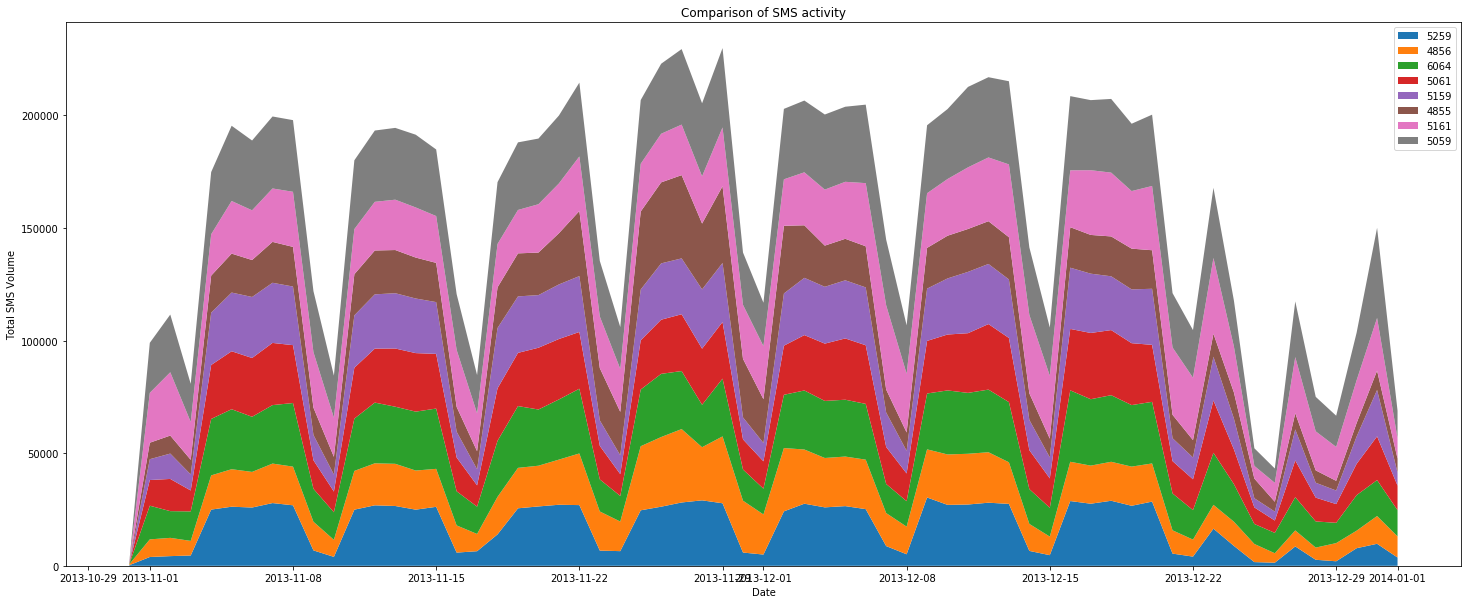

In [99]:
smsActivity = pd.DataFrame()
smsActivity['sms'] = dailyGridActivity['smsIn']+dailyGridActivity['smsOut']
topgrids = [5259, 4856, 6064, 5061, 5159, 4855, 5161, 5059]
plt.figure(figsize=(25,10))
ax = plt.stackplot(smsActivity.loc[5259].index, smsActivity.loc[5259].sms,smsActivity.loc[4856].sms,smsActivity.loc[6064].sms,
              smsActivity.loc[5061].sms, smsActivity.loc[5159].sms, smsActivity.loc[4855].sms, smsActivity.loc[5161].sms,
              smsActivity.loc[5059].sms, labels = topgrids)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total SMS Volume')
plt.title('Comparison of SMS activity')
plt.show()

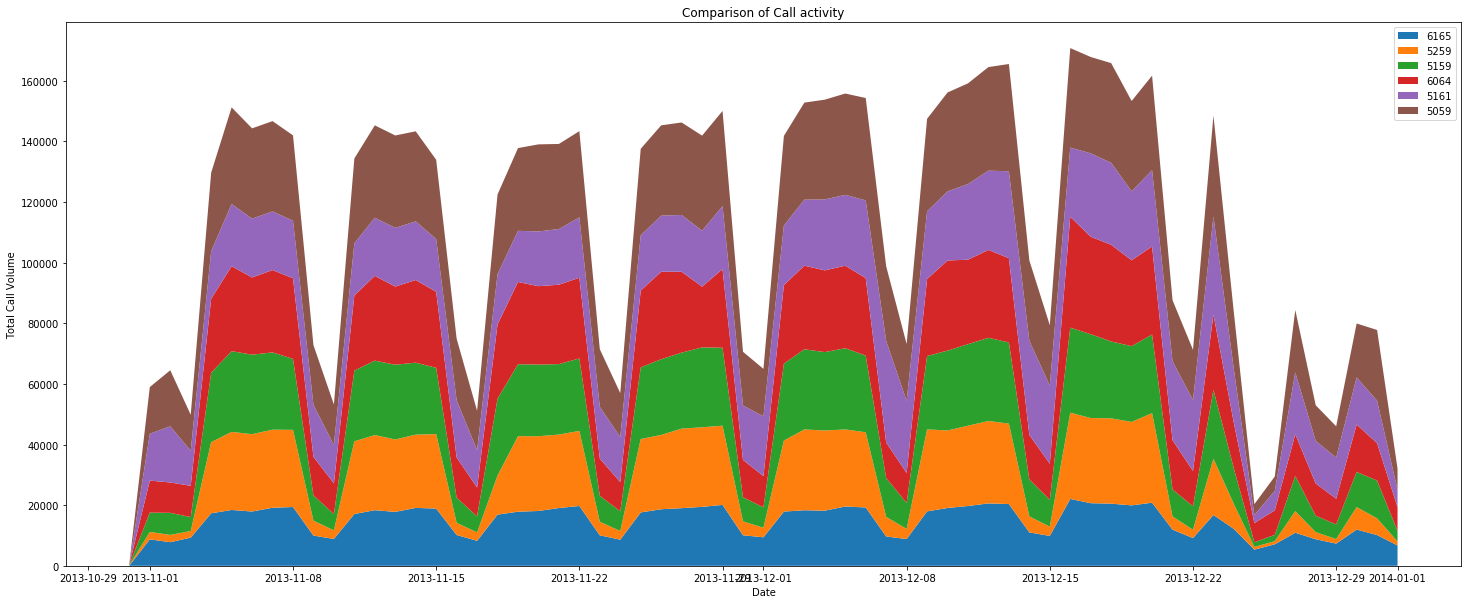

In [100]:
callActivity = pd.DataFrame()
callActivity['call'] = dailyGridActivity['callIn']+dailyGridActivity['callOut']
topgrids = [6165,5259, 5159, 6064, 5161, 5059]
plt.figure(figsize=(25,10))
ax = plt.stackplot(callActivity.loc[5059].index, callActivity.loc[6165].call,callActivity.loc[5259].call,callActivity.loc[5159].call,
              callActivity.loc[6064].call, callActivity.loc[5161].call, callActivity.loc[5059].call, labels = topgrids)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Call Volume')
plt.title('Comparison of Call activity')
plt.show()

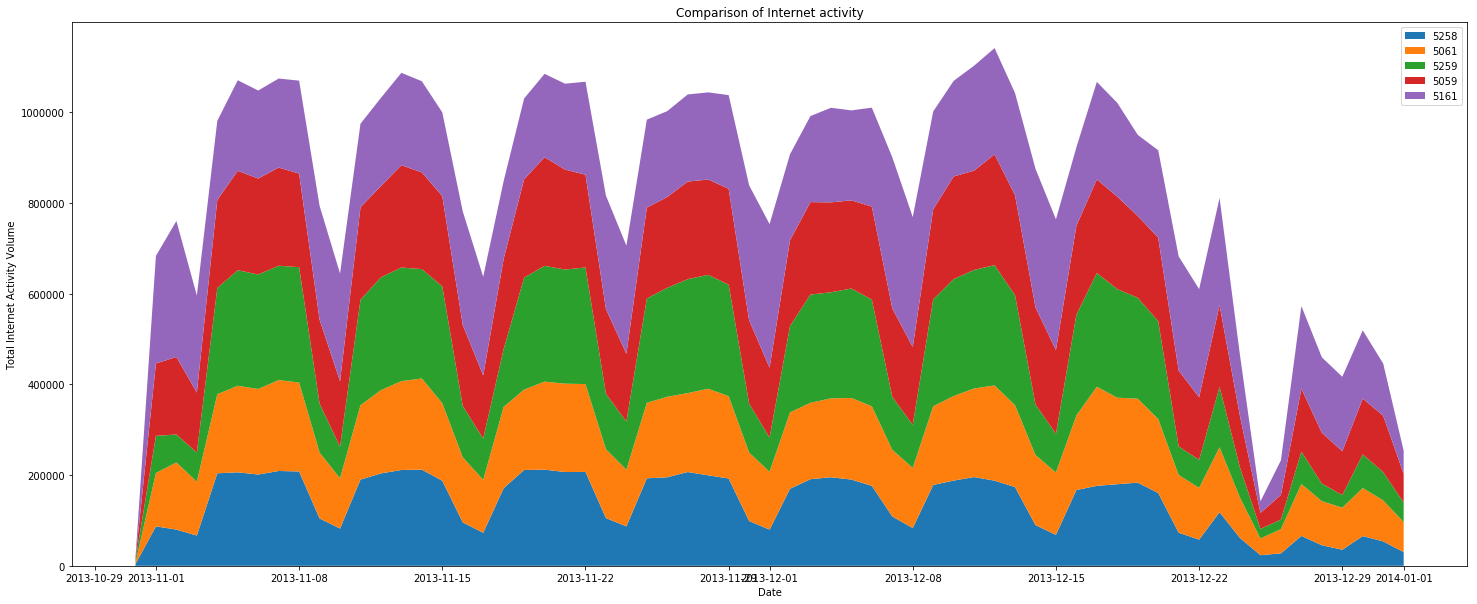

In [101]:
internetActivity = pd.DataFrame()
internetActivity['internetActivity'] = dailyGridActivity['internetActivity']
topgrids = [5258, 5061, 5259, 5059, 5161]
plt.figure(figsize=(25,10))
ax = plt.stackplot(internetActivity.loc[5059].index, internetActivity.loc[5258].internetActivity,internetActivity.loc[5061].internetActivity,
                   internetActivity.loc[5259].internetActivity,internetActivity.loc[5059].internetActivity, internetActivity.loc[5161].internetActivity, labels = topgrids)
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Internet Activity Volume')
plt.title('Comparison of Internet activity')
plt.show()

### Comparison of activities in top Grid

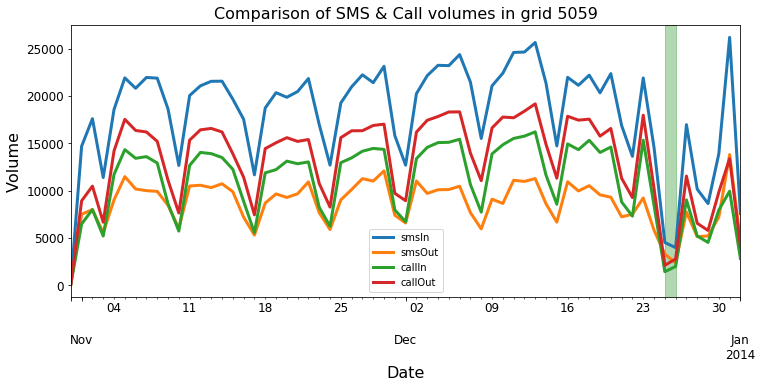

In [102]:
daily5059 = dailyGridActivity.loc[5059]
ax = daily5059.loc[:,['smsIn', 'smsOut', 'callIn', 'callOut']].plot(figsize=(12, 5), fontsize=12, linewidth=3)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Volume', fontsize=16)
ax.axvspan('2013-12-25', '2013-12-26', color='green', alpha=0.3)
ax.set_title('Comparison of SMS & Call volumes in grid 5059', fontsize=16)
plt.show()

<Figure size 1800x720 with 0 Axes>

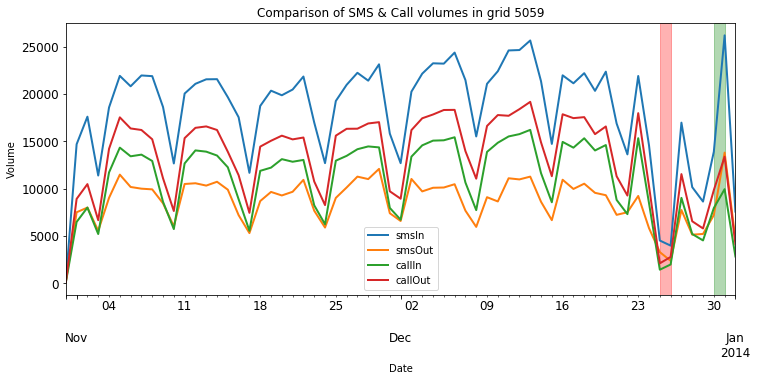

In [117]:
daily5059 = dailyGridActivity.loc[5059]
plt.figure(figsize=(25,10))
ax = daily5059.loc[:,['smsIn', 'smsOut', 'callIn', 'callOut']].plot(figsize=(12, 5), fontsize=12, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Comparison of SMS & Call volumes in grid 5059')
plt.axvspan('2013-12-25', '2013-12-26', color='red', alpha=0.3)
plt.axvspan('2013-12-30', '2013-12-31', color='green', alpha=0.3)
plt.show()



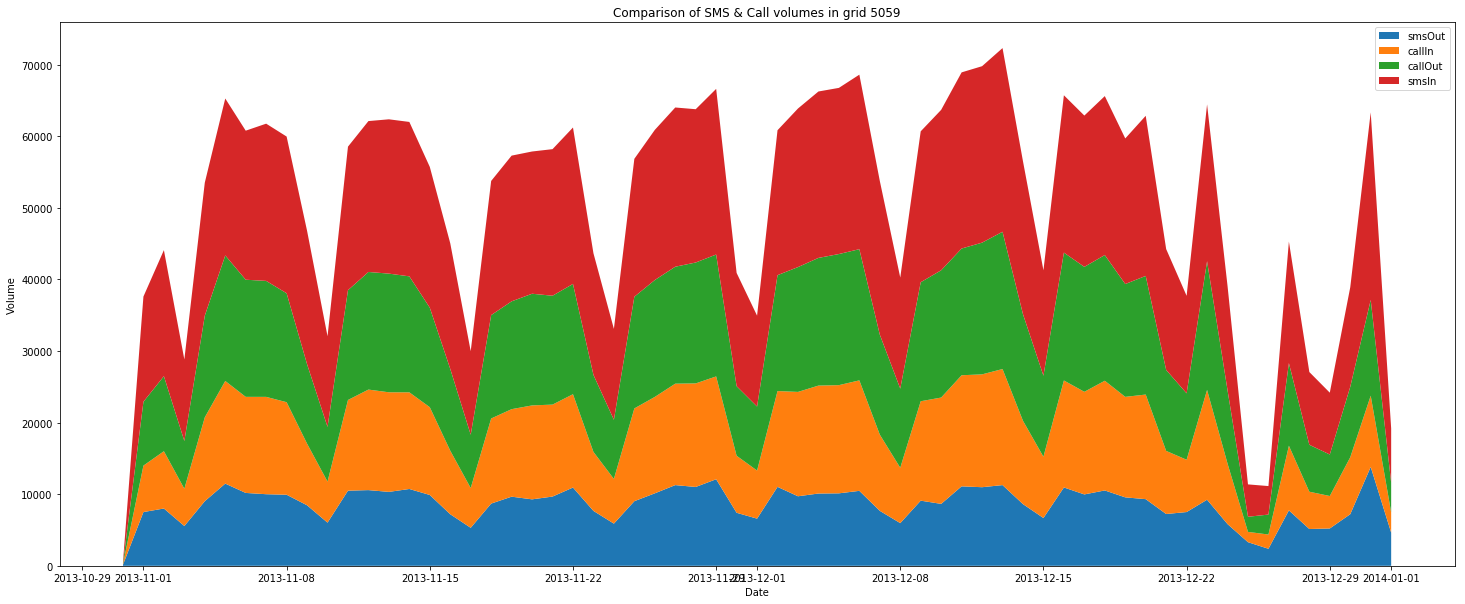

In [103]:
plt.figure(figsize=(25,10))
plt.stackplot(daily5059.index,
              daily5059.smsOut,daily5059.callIn,daily5059.callOut,daily5059.smsIn, 
              labels=['smsOut','callIn','callOut','smsIn'])
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Comparison of SMS & Call volumes in grid 5059')
plt.show()

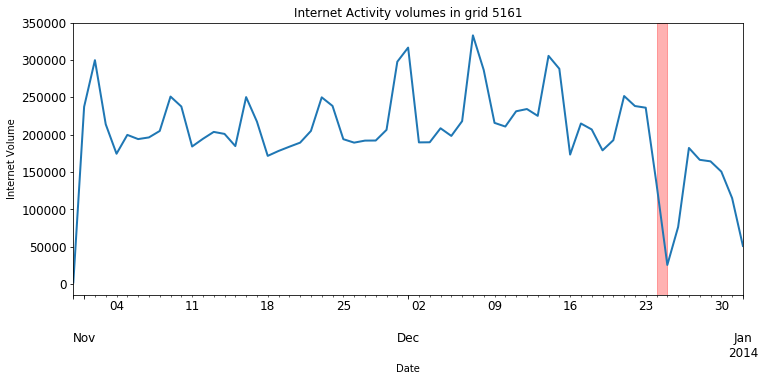

In [119]:
daily5161 = dailyGridActivity.loc[5161]
plt.figure(figsize=(25,10))
ax = daily5161['internetActivity'].plot(figsize=(12, 5), fontsize=12, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Internet Volume')
plt.title('Internet Activity volumes in grid 5161')
plt.axvspan('2013-12-24', '2013-12-25', color='red', alpha=0.3)
plt.show()

### Comparison of November and December trends for top Grid

In [282]:
novDailyGrid_5059 = dailyGridActivity.loc[5059,'2013-11']
df = dailyGridActivity.loc[5059]
decDailyGrid_5059 = df['2013-12-01':]
novDailyGrid_5161 = dailyGridActivity.loc[5161,'2013-11']
df = dailyGridActivity.loc[5161]
decDailyGrid_5161 = df['2013-12-01':]

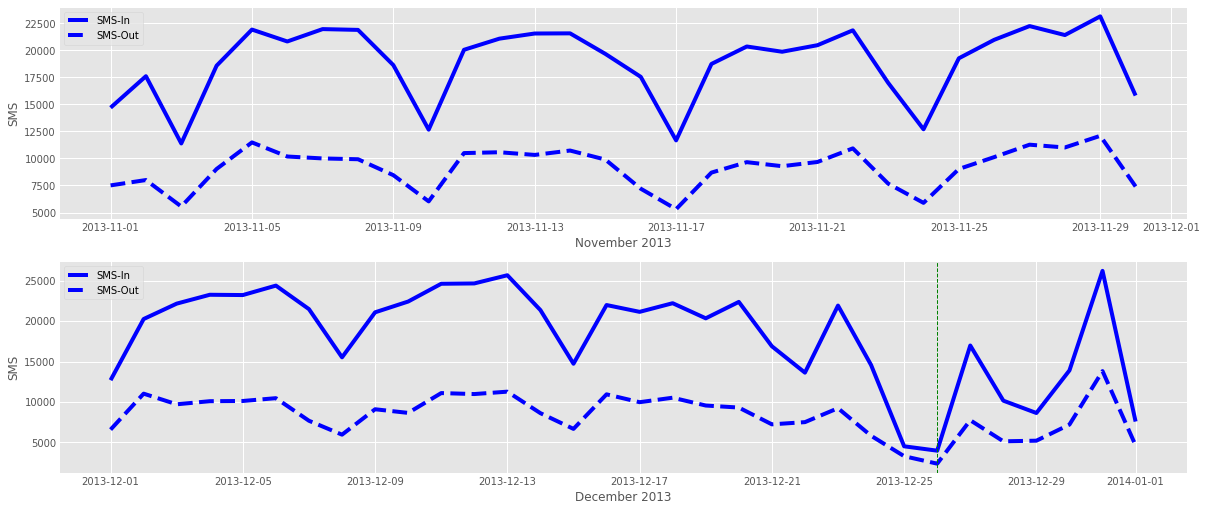

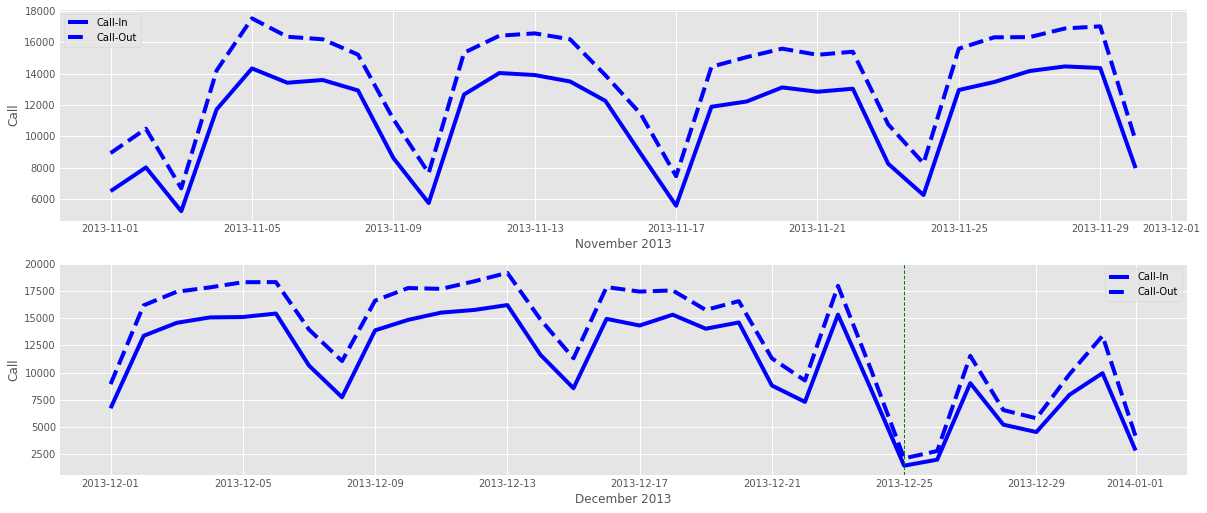

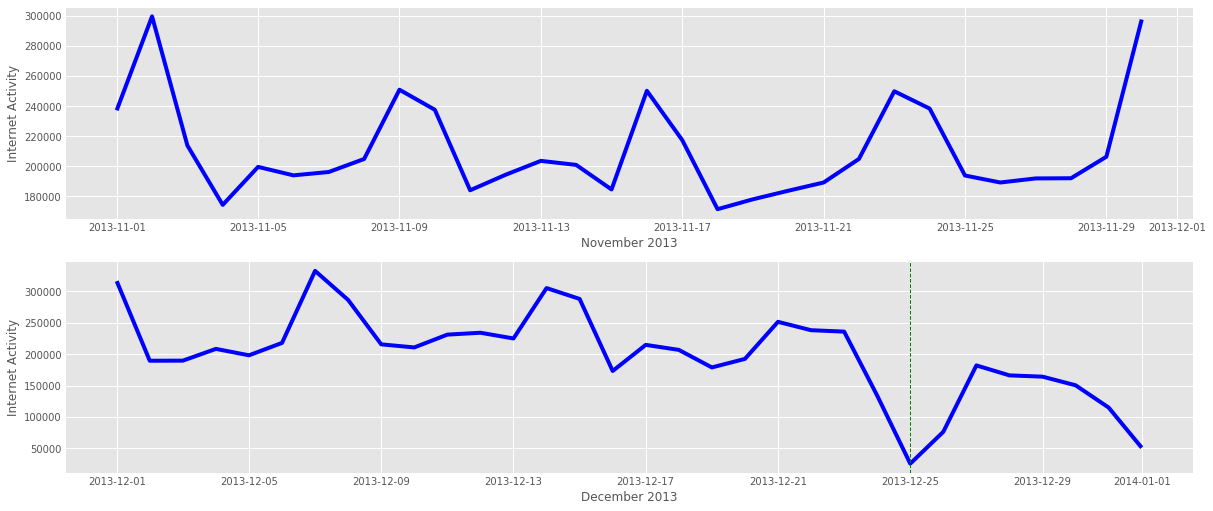

In [283]:
plt.style.use('ggplot')
plt.subplot(2,1,1)
plt.xlabel('November 2013')
plt.ylabel('SMS')
plt.plot(novDailyGrid_5059.index,novDailyGrid_5059.smsIn, 'blue', label='SMS-In')
plt.plot(novDailyGrid_5059.index,novDailyGrid_5059.smsOut,'b--', label='SMS-Out')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.xlabel('December 2013')
plt.ylabel('SMS')
plt.plot(decDailyGrid_5059.index,decDailyGrid_5059.smsIn, 'blue', label='SMS-In')
plt.plot(decDailyGrid_5059.index,decDailyGrid_5059.smsOut,'b--', label='SMS-Out')
plt.legend(loc='best')
plt.axvline('2013-12-26', linewidth=1, color='g', linestyle='dashed')
plt.show()

plt.subplot(2,1,1)
plt.xlabel('November 2013')
plt.ylabel('Call')
plt.plot(novDailyGrid_5059.index,novDailyGrid_5059.callIn, 'blue', label='Call-In')
plt.plot(novDailyGrid_5059.index,novDailyGrid_5059.callOut,'b--', label='Call-Out')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.xlabel('December 2013')
plt.ylabel('Call')
plt.plot(decDailyGrid_5059.index,decDailyGrid_5059.callIn, 'blue', label='Call-In')
plt.plot(decDailyGrid_5059.index,decDailyGrid_5059.callOut,'b--', label='Call-Out')
plt.legend(loc='best')
plt.axvline('2013-12-25', linewidth=1, color='g', linestyle='dashed')
plt.show()

plt.subplot(2,1,1)
plt.xlabel('November 2013')
plt.ylabel('Internet Activity')
plt.plot(novDailyGrid_5161.index,novDailyGrid_5161.internetActivity, 'blue')
plt.subplot(2,1,2)
plt.xlabel('December 2013')
plt.ylabel('Internet Activity')
plt.plot(decDailyGrid_5161.index,decDailyGrid_5161.internetActivity, 'blue')
plt.axvline('2013-12-25', linewidth=1, color='g', linestyle='dashed')
plt.show()

### Hourly distribution of volumes for top Grid

In [121]:
hourlyGridActivity_5059 = hourlyGridActivity.loc[5059]
hourlyGridActivity_5161 = hourlyGridActivity.loc[5161]
hourlyGridActivity_5059['dayOfWeek'] = hourlyGridActivity_5059.index.day_name()
hourlyGridActivity_5161['dayOfWeek'] = hourlyGridActivity_5161.index.day_name()
hourlyGridActivity_5059smsIn = hourlyGridActivity_5059.pivot_table(index=hourlyGridActivity_5059.index.hour,
                                                            columns='dayOfWeek', values='smsIn', aggfunc='mean')
hourlyGridActivity_5059smsOut = hourlyGridActivity_5059.pivot_table(index=hourlyGridActivity_5059.index.hour,
                                                            columns='dayOfWeek', values='smsOut', aggfunc='mean')
hourlyGridActivity_5059callIn = hourlyGridActivity_5059.pivot_table(index=hourlyGridActivity_5059.index.hour,
                                                            columns='dayOfWeek', values='callIn', aggfunc='mean')
hourlyGridActivity_5059callOut = hourlyGridActivity_5059.pivot_table(index=hourlyGridActivity_5059.index.hour,
                                                            columns='dayOfWeek', values='callOut', aggfunc='mean')
hourlyGridActivity_5161internet = hourlyGridActivity_5161.pivot_table(index=hourlyGridActivity_5161.index.hour,
                                                            columns='dayOfWeek', values='internetActivity', aggfunc='mean')

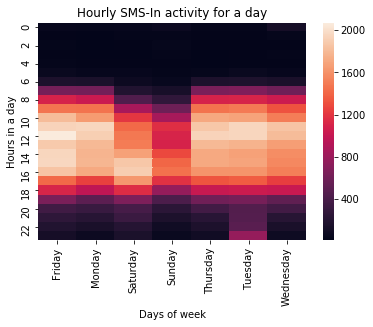

In [139]:
import seaborn as sns
ax = sns.heatmap(hourlyGridActivity_5059smsIn)
plt.title('Hourly SMS-In activity for a day')
plt.xlabel('Days of week')
plt.ylabel('Hours in a day')
plt.show()

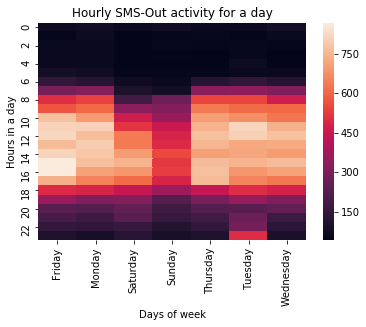

In [140]:
ax = sns.heatmap(hourlyGridActivity_5059smsOut)
plt.title('Hourly SMS-Out activity for a day')
plt.xlabel('Days of week')
plt.ylabel('Hours in a day')
plt.show()

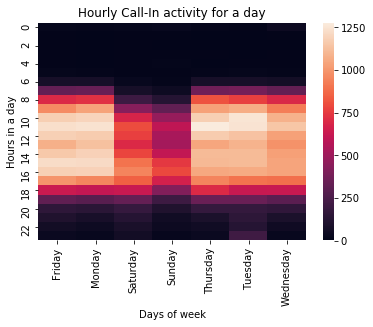

In [141]:
ax = sns.heatmap(hourlyGridActivity_5059callIn)
plt.title('Hourly Call-In activity for a day')
plt.xlabel('Days of week')
plt.ylabel('Hours in a day')
plt.show()

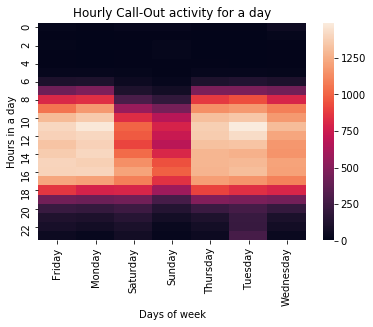

In [142]:
ax = sns.heatmap(hourlyGridActivity_5059callOut)
plt.title('Hourly Call-Out activity for a day')
plt.xlabel('Days of week')
plt.ylabel('Hours in a day')
plt.show()

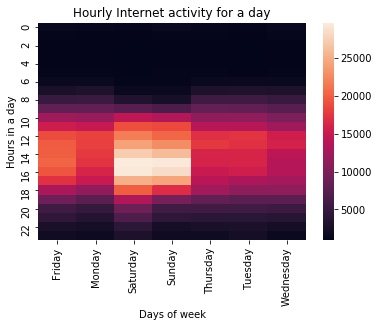

In [134]:
ax = sns.heatmap(hourlyGridActivity_5161internet)
plt.title('Hourly Internet activity for a day')
plt.xlabel('Days of week')
plt.ylabel('Hours in a day')
plt.show()

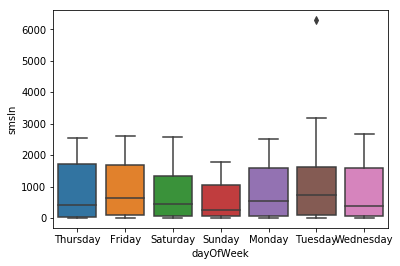

In [127]:

ax = sns.boxplot(hourlyGridActivity_5059['dayOfWeek'], hourlyGridActivity_5059['smsIn'])

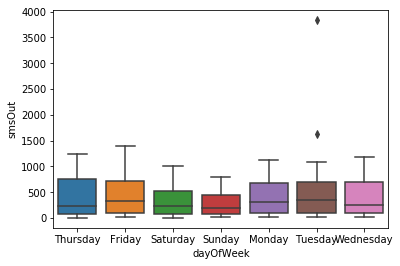

In [128]:
ax = sns.boxplot(hourlyGridActivity_5059['dayOfWeek'], hourlyGridActivity_5059['smsOut'])

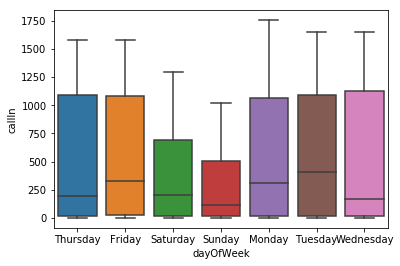

In [129]:
ax = sns.boxplot(hourlyGridActivity_5059['dayOfWeek'], hourlyGridActivity_5059['callIn'])

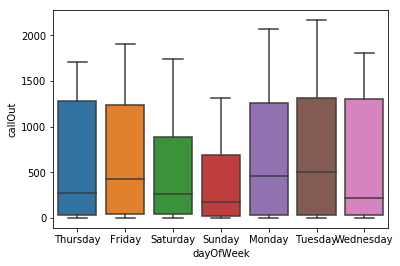

In [130]:
ax = sns.boxplot(hourlyGridActivity_5059['dayOfWeek'], hourlyGridActivity_5059['callOut'])

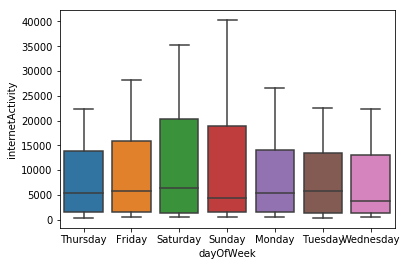

In [126]:
ax = sns.boxplot(hourlyGridActivity_5161['dayOfWeek'], hourlyGridActivity_5161['internetActivity'])

### Time Series Decomposition of the top Grid Id in each category

In [284]:
import statsmodels.api as sm
from pylab import rcParams

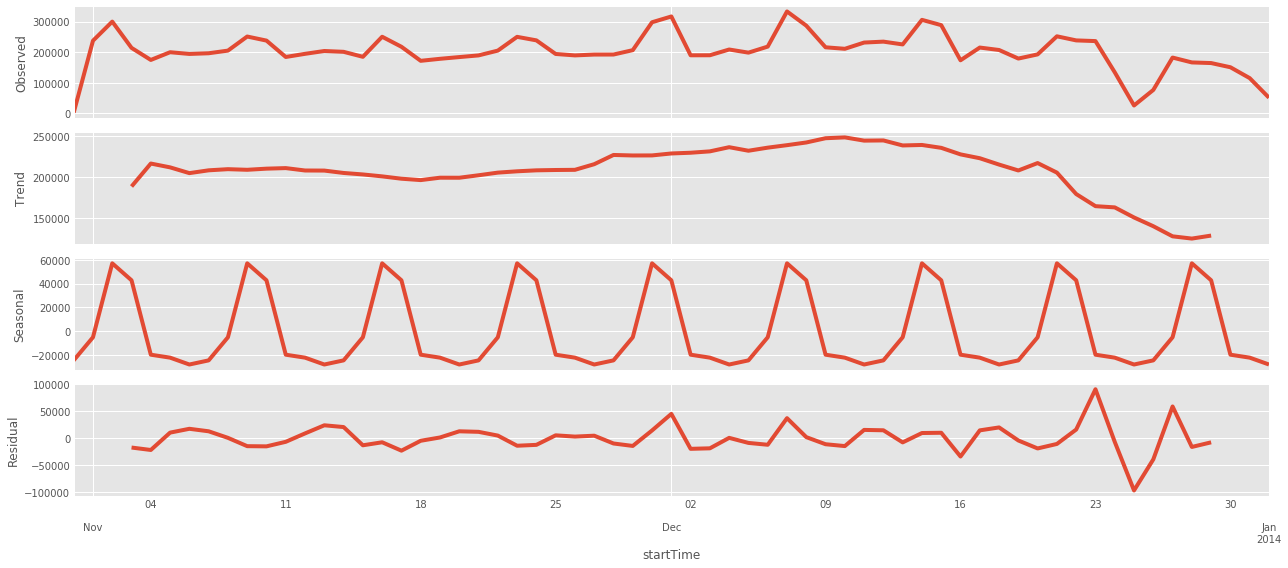

In [285]:
dailyInternetActivity_5161= dailyGridActivity.loc[5161][['internetActivity']]
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(dailyInternetActivity_5161, model='additive')
fig = decomposition.plot()
plt.show()

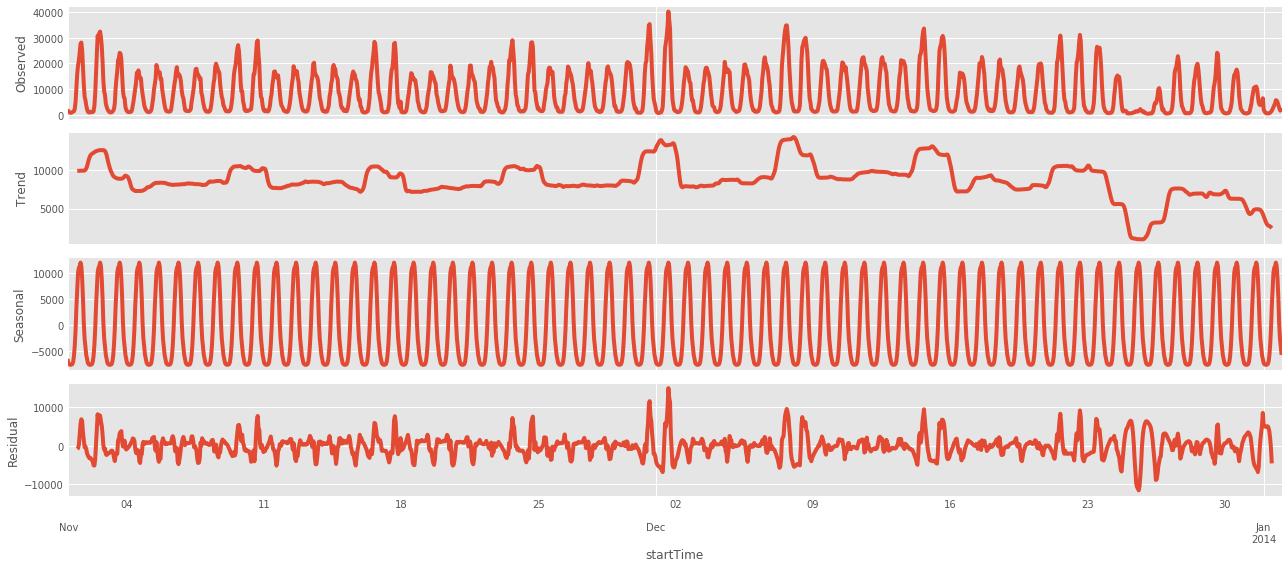

In [286]:
hourlyGridActivity_5161 = hourlyGridActivity.loc[5161][['internetActivity']]
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(hourlyGridActivity_5161, model='additive')
fig = decomposition.plot()
plt.show()

In [288]:
hourlyGridActivity_5161.head(20)

,internetActivity
startTime,
2013-10-31 23:00:00,2125.890955
2013-11-01 00:00:00,1203.833926
2013-11-01 01:00:00,917.216728
2013-11-01 02:00:00,814.360530
2013-11-01 03:00:00,721.338448
2013-11-01 04:00:00,792.938323
2013-11-01 05:00:00,1044.338343
2013-11-01 06:00:00,1192.342622
2013-11-01 07:00:00,1353.479435
